# Baynes Upwelling Run Comparisons

This notebook uses sequential cases beginning with the full configuration to see whether an upwelling event can be preserved along the Baynes Sound coastal section of Vancouver Island.

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from dateutil.parser import parse
from cmocean import cm
from salishsea_tools import grid_tools, utilities, viz_tools, places

%matplotlib inline

***

### Load wind and hindcast results

In [3]:
# Timerange (datetime objects)
daterange = [parse(t) for t in ['2015 Apr 24 00:00', '2015 Apr 29 00:00']]
xrange = [100, 398]
yrange = [300, 898]
dims = [int(np.diff(yrange)), int(np.diff(xrange))]

# Results path
path = '/results/SalishSea/hindcast.201812'
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
bathy = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02')

# Initialize storage arrays
date = np.empty(0, dtype='object')
tracer = np.empty((0, *dims))
temperature = np.empty((0, 40, dims[1]))
salinity = np.empty((0, 40, dims[1]))

# Iterate over number of days in daterange
bar = utilities.statusbar('Loading ...')
for day in bar(range(np.diff(daterange)[0].days)):
    
    # Make date and datestrings
    datestamp = daterange[0] + timedelta(days=day)
    datestr1 = datestamp.strftime('%d%b%y').lower()
    datestr2 = datestamp.strftime('%Y%m%d')
    
    # Open netCDF
    fn = f'SalishSea_1h_{datestr2}_{datestr2}_mtrc_T.nc'
    with xr.open_dataset(os.path.join(path, datestr1, fn)) as T:
    
        # Slice, format, and concatenate results
        date = np.concatenate((date, T.time_counter.values.astype('datetime64[s]').astype(datetime)), axis=0)
        tracer = np.concatenate((tracer, T.tracer20m[:, 0, ...].values), axis=0)
    
    # Open netCDF
    fn = f'SalishSea_1h_{datestr2}_{datestr2}_grid_T.nc'
    with xr.open_dataset(os.path.join(path, datestr1, fn)) as T:
        
        # Slice, format, and concatenate results
        temperature = np.concatenate((temperature, T.votemper[..., 625, slice(*xrange)].values), axis=0)
        salinity = np.concatenate((salinity, T.vosaline[..., 625, slice(*xrange)].values), axis=0)

Loading ... 100% (5 of 5) |################################################|Time: 0:01:14


In [163]:
grid_GEM = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
mask_GEM = grid_tools.build_GEM_mask(grid_GEM, bathy, mask.tmask[0, 0, ...])

Building GEM mask 100% (68096 of 68096) |###################################|Time: 0:07:52


In [120]:
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
fn = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1'
GEM = xr.open_dataset(fn).sel(time=slice(*daterange)).isel(gridY=j, gridX=i)
U_mag = np.sqrt(GEM.u_wind**2 + GEM.v_wind**2)
U_angle = np.degrees(np.arctan(GEM.v_wind / GEM.u_wind))

***

## 2015 Apr 24 - 29 upwelling event near Baynes Sound

### HRDPS record at Sentry Shoal

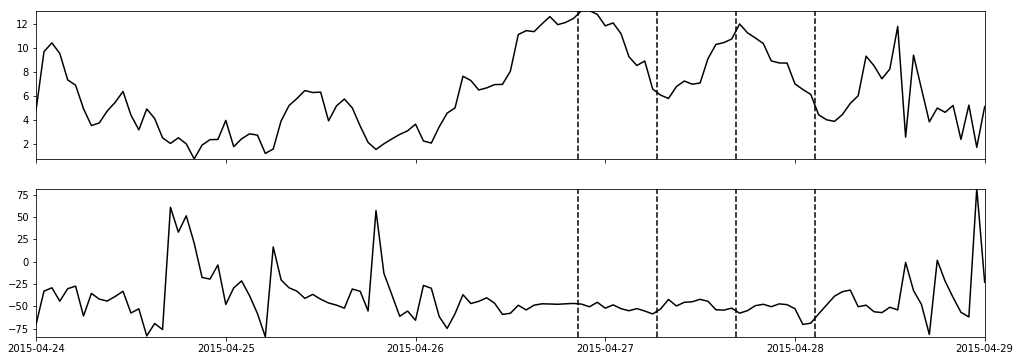

In [132]:
xlim = [GEM.time[0].values, GEM.time[-1].values]
fig, axs = plt.subplots(2, 1, figsize=(17, 6))
axs[0].xaxis.set_ticklabels(' ')
for ax, qty in zip(axs, [U_mag, U_angle]):
    ylim = [qty.min(), qty.max()]
    ax.plot(GEM.time, qty, 'k-')
    for t in [68, 78, 88, 98]:
        ax.plot([date[t], date[t]], ylim, 'k--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

### Hindcast

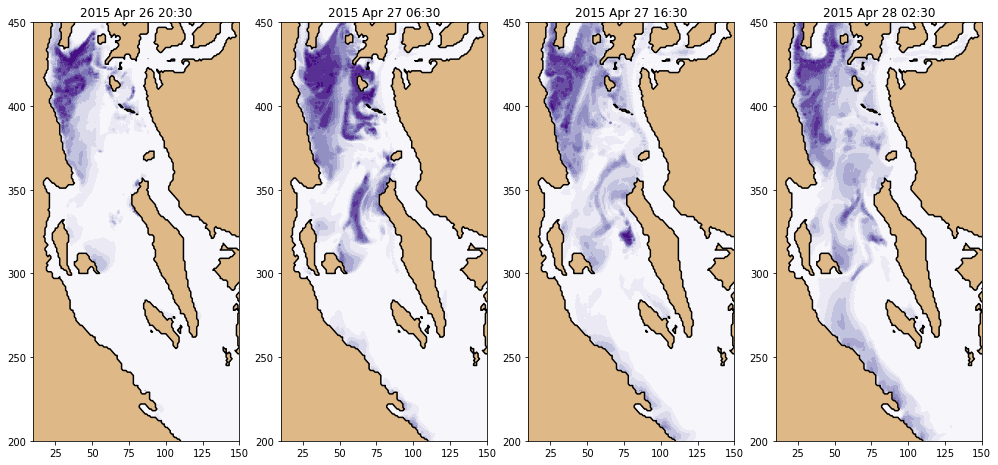

In [55]:
# Plot surface tracer
fig, axs = plt.subplots(1, 4, figsize=(17, 8))
for ax, t in zip(axs, [68, 78, 88, 98]):
    ax.contourf(T.x, T.y, tracer[t, ...], levels=np.arange(0, 1.1, 0.1), cmap=plt.get_cmap('Purples'))
    ax.contourf(T.x, T.y, mask.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(T.x, T.y, mask.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([10, 150])
    ax.set_ylim([200, 450])
    ax.set_title(date[t].strftime('%Y %b %d %H:%M'))
    viz_tools.set_aspect(ax)

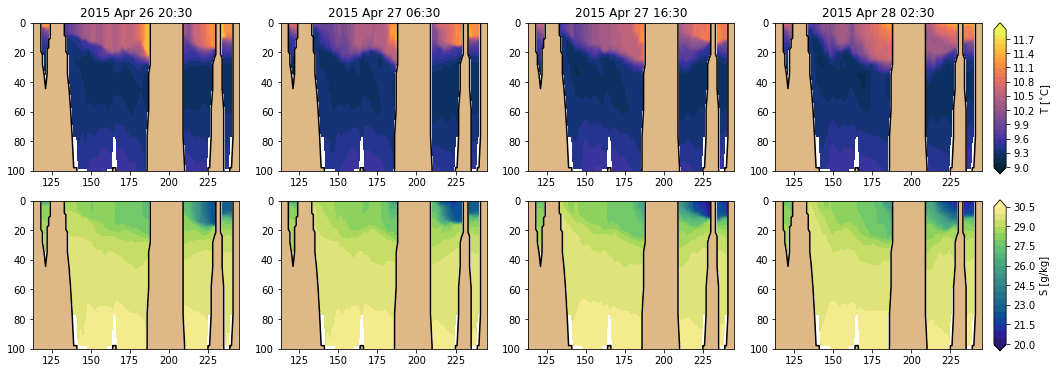

In [49]:
# Plot sections
fig, axs = plt.subplots(2, 4, figsize=(17, 6))
caxs = [fig.add_axes([0.91, y, 0.01, 0.35]) for y in [0.53, 0.12]]
for row, qty, label, levels, cmap, cax in zip(axs, [temperature, salinity], ['T [$^{\circ}$C]', 'S [g/kg]'], [[9, 12, 0.1], [20, 31, 0.5]], [cm.thermal, cm.haline], caxs):
    for ax, t in zip(row, [68, 78, 88, 98]):
        qty_ma = np.ma.masked_where(mask.tmask[0, :, 625, slice(*xrange)] == 0, qty[t, ...])
        c = ax.contourf(T.x[slice(*xrange)], T.deptht, qty_ma, levels=np.arange(*levels), cmap=cmap, extend='both')
        ax.contourf(T.x[slice(*xrange)], T.deptht, mask.tmask[0, :, 625, slice(*xrange)], levels=[-0.01, 0.01], colors='burlywood')
        ax.contour(T.x[slice(*xrange)], T.deptht, mask.tmask[0, :, 625, slice(*xrange)], levels=[-0.01, 0.01], colors='k')
        ax.set_xlim([113, 245])
        ax.set_ylim([100, 0])
        if label is 'T [$^{\circ}$C]':
            ax.set_title(date[t].strftime('%Y %b %d %H:%M'))
    fig.colorbar(c, cax=cax, label=label)

### Coldstart

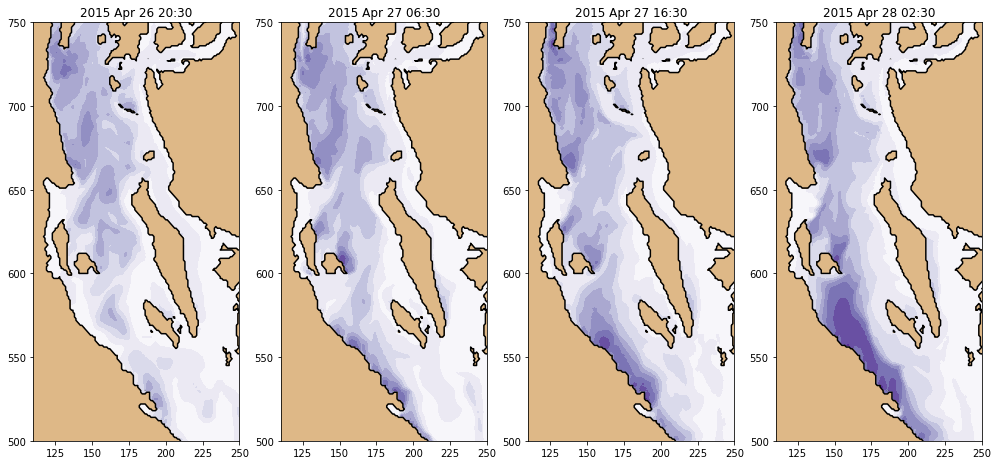

In [50]:
fn = '/data/vdo/MEOPAR/completed-runs/stats-runs2/25apr15/SalishSea_1h_20150425_20150429_ptrc_T.nc'
T = xr.open_dataset(fn)
fig, axs = plt.subplots(1, 4, figsize=(17, 8))
for ax, t in zip(axs, [44, 54, 64, 74]):
    ax.contourf(T.x, T.y, T.mytracer1[t, 0, ...], levels=np.arange(0, 1.1, 0.1), cmap=plt.get_cmap('Purples'))
    ax.contourf(T.x, T.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(T.x, T.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([110, 250])
    ax.set_ylim([500, 750])
    ax.set_title(T.time_counter[t].values.astype('datetime64[s]').astype(datetime).strftime('%Y %b %d %H:%M'))
    viz_tools.set_aspect(ax)

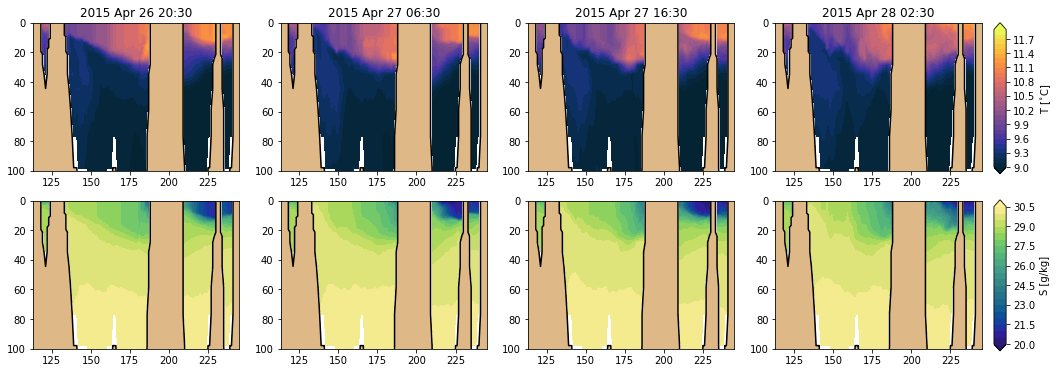

In [59]:
fn = '/data/vdo/MEOPAR/completed-runs/stats-runs2/25apr15/SalishSea_1h_20150425_20150429_grid_T.nc'
T = xr.open_dataset(fn)
fig, axs = plt.subplots(2, 4, figsize=(17, 6))
caxs = [fig.add_axes([0.91, y, 0.01, 0.35]) for y in [0.53, 0.12]]
for row, qty, label, levels, cmap, cax in zip(axs, ['votemper', 'vosaline'], ['T [$^{\circ}$C]', 'S [g/kg]'], [[9, 12, 0.1], [20, 31, 0.5]], [cm.thermal, cm.haline], caxs):
    for ax, t in zip(row, [44, 54, 64, 74]):
        qty_ma = np.ma.masked_where(mask.tmask[0, :, 625, :] == 0, T[qty][t, :, 625, :])
        c = ax.contourf(T.x, T.deptht, qty_ma, levels=np.arange(*levels), cmap=cmap, extend='both')
        ax.contourf(T.x, T.deptht, mask.tmask[0, :, 625, :], levels=[-0.01, 0.01], colors='burlywood')
        ax.contour(T.x, T.deptht, mask.tmask[0, :, 625, :], levels=[-0.01, 0.01], colors='k')
        ax.set_xlim([113, 245])
        ax.set_ylim([100, 0])
        if label is 'T [$^{\circ}$C]':
            ax.set_title(T.time_counter[t].values.astype('datetime64[s]').astype(datetime).strftime('%Y %b %d %H:%M'))
    fig.colorbar(c, cax=cax, label=label)

### Lake

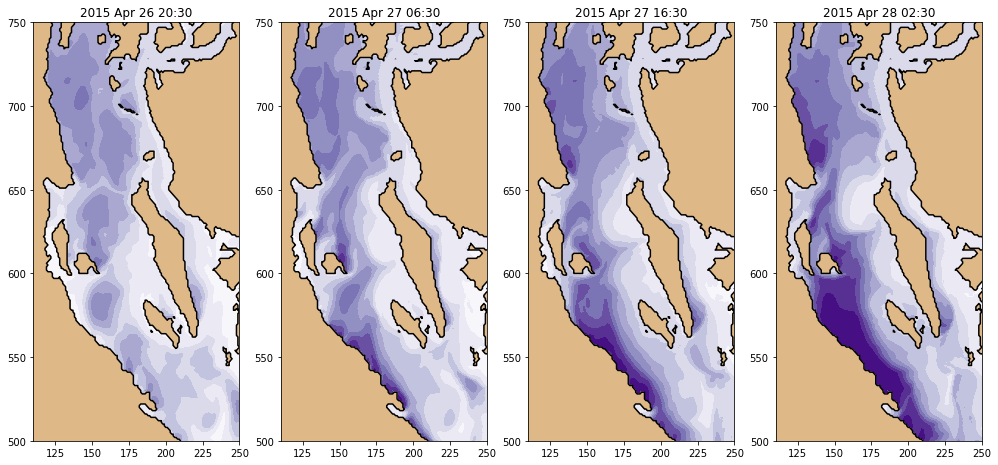

In [85]:
fn = '/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15lake/SalishSea_1h_20150424_20150429_ptrc_T.nc'
T = xr.open_dataset(fn)
fig, axs = plt.subplots(1, 4, figsize=(17, 8))
for ax, t in zip(axs, [68, 78, 88, 98]):
    ax.contourf(T.x, T.y, T.mytracer1[t, 0, ...], levels=np.arange(0, 1.1, 0.1), cmap=plt.get_cmap('Purples'))
    ax.contourf(T.x, T.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(T.x, T.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([110, 250])
    ax.set_ylim([500, 750])
    ax.set_title(T.time_counter[t].values.astype('datetime64[s]').astype(datetime).strftime('%Y %b %d %H:%M'))
    viz_tools.set_aspect(ax)

### Analytic wind forcing

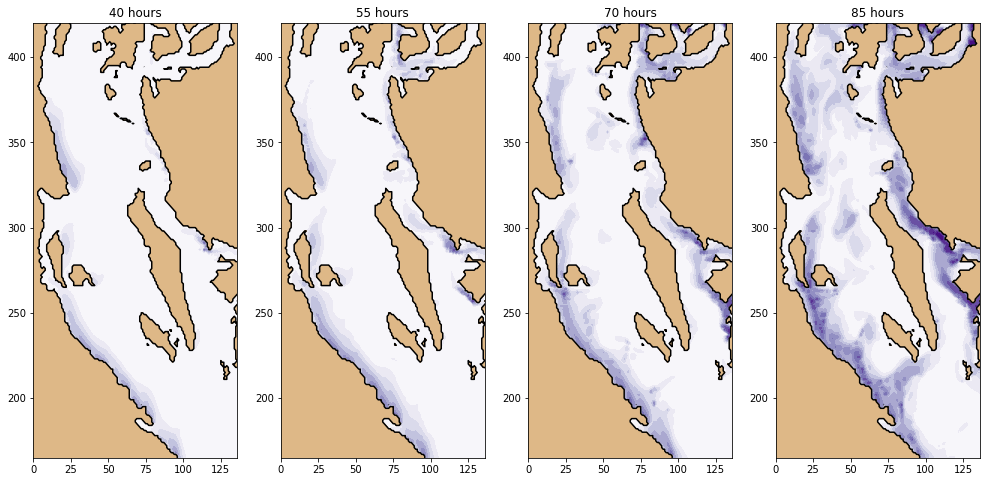

In [152]:
fn = '/data/bmoorema/results/pond/lake/SalishSeaPond_lake_S4d/SalishSeaIdeal_1h_20170701_20170706_grid_T.nc'
xrange = [114, 398]
yrange = [334, 898]
T = xr.open_dataset(fn)
fig, axs = plt.subplots(1, 4, figsize=(17, 8))
for ax, t in zip(axs, [40, 55, 70, 85]):
    ax.contourf(T.x, T.y, T.tracer20m[t, 0, ...], levels=np.arange(0, 1.1, 0.1), cmap=plt.get_cmap('Purples'))
    ax.contourf(T.x, T.y, mask.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='burlywood')
    ax.contour(T.x, T.y, mask.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='k')
    viz_tools.set_aspect(ax)
    ax.set_xlim([0, 136])
    ax.set_ylim([165, 420])
    ax.set_title(f'{t} hours')

### HRDPS fields

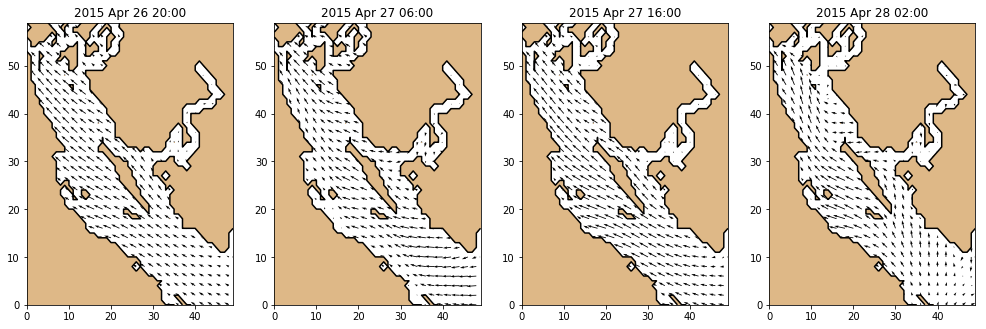

In [184]:
fn = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1'
xrange = [100, 150]
yrange = [140, 200]
GEM = xr.open_dataset(fn).sel(time=slice(*daterange)).isel(gridY=slice(*yrange), gridX=slice(*xrange))
fig, axs = plt.subplots(1, 4, figsize=(17, 8))
for ax, t in zip(axs, [68, 78, 88, 98]):
    ax.quiver(np.arange(25)*2, np.arange(30)*2, GEM.u_wind[t, ::2, ::2], GEM.v_wind[t, ::2, ::2], width=0.004)
    ax.contourf(mask_GEM[slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='Burlywood')
    ax.contour(mask_GEM[slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='k')
    ax.set_title(GEM.time[t].values.astype('datetime64[s]').astype(datetime).strftime('%Y %b %d %H:%M'))
    viz_tools.set_aspect(ax)

***

## 2016 May 8 upwelling event near Baynes Sound

In [ ]:
# Make figure layout
fig = plt.figure(figsize=(17, 10))
gs = GridSpec(2, 4, height_ratios=[1, 5])
xrange = [100, 398]
yrange = [300, 898]
    
# Extract HRDPS data
eventlist = [HRDPS.sel(time=slice(*eventwindow)).isel(gridY=j, gridX=i)[key].values for key in ['u_wind', 'v_wind']]
event = {
    'time': HRDPS.sel(time=slice(*eventwindow)).time.values.astype('datetime64[s]').astype(datetime),
    'magnitude': np.sqrt(sum([component**2 for component in eventlist])),
    'angle': np.degrees(np.arctan(np.divide(*eventlist[::-1]))),
}

# Plot HRDPS data
ax = fig.add_subplot(gs[row, :])
ax.set_xlim(eventwindow)
for axis, key, color, ylim in zip([ax, ax.twinx()], ['magnitude', 'angle'], ['black', 'lightgray'], [[0, 18], [-100, 100]]):
    axis.plot(event['time'], event[key], '-', color=color)
    axis.xaxis.set_major_locator(mdates.DayLocator())
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    axis.set_ylim(ylim)

# Loop through individual dates
for col in range(4):

    # Extract NEMO data
    date = eventwindow[0] + (col + 1) * np.diff(eventwindow)[0] / 5
    datestr = date.strftime('%Y%m%d')
    if date.year > 2016:
        path = path_NEMO_annex
    else:
        path = path_NEMO
    fn = os.path.join(path, date.strftime('%d%b%y').lower(), f'SalishSea_1h_{datestr}_{datestr}_mtrc_T.nc')
    data = xr.open_dataset(fn).sel(time_counter=date, method='nearest')

    # Plot NEMO data
    ax_map = fig.add_subplot(gs[row+1, col])
    c = ax_map.contourf(data.x, data.y, data.tracer20m[0, ...], levels=np.arange(0, 1.1, 0.1), cmap=plt.get_cmap('Purples'), extend='both')
    ax_map.contourf(mask.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='Burlywood')
    ax_map.contour(mask.tmask[0, 0, slice(*yrange), slice(*xrange)], levels=[-0.01, 0.01], colors='k')
    ax_map.plot(52, 312, 'ko', markerfacecolor='r', markersize=8)
    ax_map.plot(66, 257, 'ko', markerfacecolor='r', markersize=8)
    ax_map.set_xlim([10, 150])
    ax_map.set_ylim([200, 450])
    viz_tools.set_aspect(ax_map)

    # Mark date on HRDPS record
    ax.plot([date, date], [0, 18], 'k--')